<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

## Model Interpretation for Pretrained ImageNet Model using RISE

This notebook demonstrates how to apply RISE algorithms on pretrained ImageNet model using a car image and visualizes the attributions for each pixel/super-pixel by displaying them on the image.<br>

RISE is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates importance empirically by probing the model with randomly masked versions of the input image and obtaining the corresponding outputs.<br>

More details about this method can be found in the paper https://arxiv.org/abs/1806.07421.<br>


In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
# keras model and preprocessing tools
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing import image
# dianna library for explanation
import dianna
from dianna import visualization
# for plotting
%matplotlib inline
from matplotlib import pyplot as plt

## 1 - Loading the model and the dataset
Loads pretrained ImageNet model and the image to be explained.

Initialize the pretrained model.

In [2]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

In [3]:
model = Model()

2022-02-01 14:52:36.168129: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load and preprocess image.

In [4]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    return img, x

Call the function to load an image of a single instance in the test data from the `img` folder.

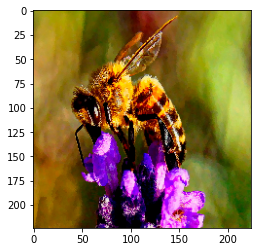

In [5]:
img, x = load_img('./img/bee.jpg')
plt.imshow(img)

## 2 - Compute attributions and visualize the saliency
Compute attributions using RISE and visualize the saliency on the image. 

RISE masks random portions of the input image and passes this image through the model — the mask that damages accuracy the most is the most “important” portion.<br>
To call the explainer and generate saliency map, the user need to specified the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and for each mask and each feature in the image, the probability of being kept unmasked (`p_keep`).

In [7]:
heatmaps = dianna.explain_image(model.run_on_batch, x, method="RISE",
                                labels=[i for i in range(1000)],
                                n_masks=1000, feature_res=6, p_keep=.1,
                                axis_labels={2: 'channels'})

Explaining: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.17s/it]


Make predictions and select the top prediction.


In [16]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

# print the name of predicted class, taking care of adding a batch axis to the model input
class_name(np.argmax(model.model.predict(x[None, ...])))

'bee'

Visualize the saliency map on the image for the predicted class.

Explanation for `bee`


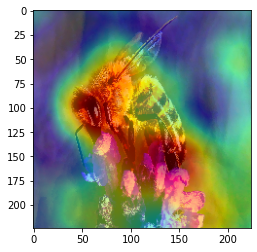

In [18]:
class_idx = np.argmax(model.model.predict(x[None, ...]))
print(f'Explanation for `{class_name(class_idx)}`')
visualization.plot_image(heatmaps[class_idx], image.img_to_array(img)/255., heatmap_cmap='jet')

## 3 - Conclusions
These saliency maps are generated by passing multiple randomly masked input to the black-box model and averaging their importance scores. The idea behind this is that whenever a mask preserves important parts of the image it gets higher score. <br>

The example here shows that the RISE method evaluates the importance of each pixel/super pixel to the classification. Pixels depicting the sports car are highlighted by the XAI approach, which implies how the model classifies the item in the image. The results are reasonable based on human visual preception of the testing image.